## Weddell Sea surface freshwater budget

In [4]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import plot_ts_distribution

In [5]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mesh= f'{base_dir}bathymetry/mesh_mask-20240305.nc'
run_dir  = f'{base_dir}output/ERA5_test7/'

In [28]:
gridT_files = np.sort(glob.glob(f'{run_dir}files/*grid_T*'))
gridU_files = np.sort(glob.glob(f'{run_dir}files/*grid_U*'))
gridV_files = np.sort(glob.glob(f'{run_dir}files/*grid_V*'))
SBC_files   = np.sort(glob.glob(f'{run_dir}files/*SBC*'))
ice_files   = np.sort(glob.glob(f'{run_dir}files/*icemod*'))

ds_mesh = xr.open_dataset(nemo_mesh)
ds_gridT= xr.open_dataset(gridT_files[0])
ds_gridU= xr.open_dataset(gridU_files[0])
ds_gridV= xr.open_dataset(gridV_files[0])
ds_SBC  = xr.open_dataset(SBC_files[0]).rename({'x_grid_T':'x','y_grid_T':'y'})
ds_ice  = xr.open_dataset(ice_files[0])

Components to account for:
- evaporation (wfo?, kg/m2/s from both sea ice and ocean water)
- precipitation (snowfall snowpre, kg/m2/s, total precipitation precip)
- ~~runoff (runoffs, kg/m2/s)~~
- sea ice melt/formation (vfxice kg/m2/s, ice-ocean mass flux from ice melt/growth (neg = growth), sfxice, ice-ocean salt flux from ice growth/melt (neg = growth))
- iceberg melt (iceberg_cea, kg/m2/s)
- iceshelf freshwater flux (fwfisf, kg/m2/s)
- ~~water_flux_out_of_sea_water_due_to_newtonian_relaxation (erp, kg/m2/s)~~

Boundary transports?

In [9]:
# regions:
weddell_basin      = {'x': slice(950, 1150, None), 'y': slice(295, 360, None)} # very similar to weddell convect but withwout shelf edge
weddell_west_shelf = {'x': slice(918, 967, None), 'y': slice(245, 310, None)}
weddell_overall    = {'x': slice(850, 1200, None), 'y': slice(50, -1, None)}

In [120]:
ds_SBC  = xr.open_mfdataset(SBC_files[0:15]).rename({'x_grid_T':'x','y_grid_T':'y'})
ds_ice  = xr.open_mfdataset(ice_files[0:15])

In [121]:
water_flux_into_ocean = ds_SBC['precip'].isel(**weddell_overall) +  \
                        ds_SBC['runoffs'].isel(**weddell_overall) + ds_SBC['berg_melt'].isel(**weddell_overall) + \
                        ds_SBC['fwfisf'].isel(**weddell_overall) + ds_ice['vfxice'].isel(**weddell_overall)
# (-1*ds_SBC['wfo'].isel(**weddell_overall)) + 

# wfo seems to include vfxice already

water_flux_into_ocean = xr.where(water_flux_into_ocean==0, np.nan, water_flux_into_ocean)
# convert from kg/m2/s * m3/kg = m/s * s/yr --> m/yr
# 1 kg/m2/s * 1e-3 m3/kg = m/s * s/year = m / yr
sec_per_year = 3600*24*365
water_flux_into_ocean = water_flux_into_ocean * 1e-3 *sec_per_year / (5*12)

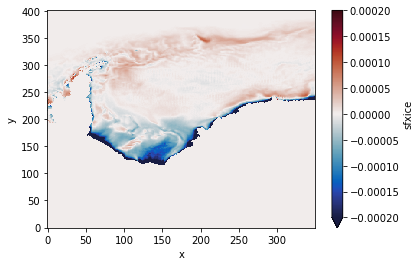

In [136]:
ds_ice['sfxice'].isel(**weddell_overall).sum(dim='time_counter').plot(vmin=-2e-4, vmax=2e-4, cmap=cmocean.cm.balance)

Problems do seem to originate from regions with strong sea ice formation. Double-check the growth rates and whether those are vaguely reasonable.

In [122]:
wfo    = -1*(ds_SBC['wfo'].isel(**weddell_overall).sum(dim='time_counter')* 1e-3 *sec_per_year / (5*12))
vfxice = (ds_ice['vfxice'].isel(**weddell_overall).sum(dim='time_counter')* 1e-3 *sec_per_year / (5*12))
precip = (ds_SBC['precip'].isel(**weddell_overall).sum(dim='time_counter')* 1e-3 *sec_per_year / (5*12))
bergmelt = (ds_SBC['berg_melt'].isel(**weddell_overall).sum(dim='time_counter')* 1e-3 *sec_per_year / (5*12))
fwfisf   = (ds_SBC['fwfisf'].isel(**weddell_overall).sum(dim='time_counter')* 1e-3 *sec_per_year / (5*12))

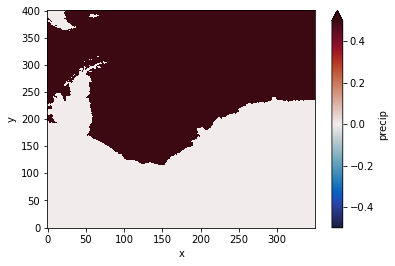

In [130]:
precip.plot(vmin=-0.5, vmax=0.5, cmap=cmocean.cm.balance)

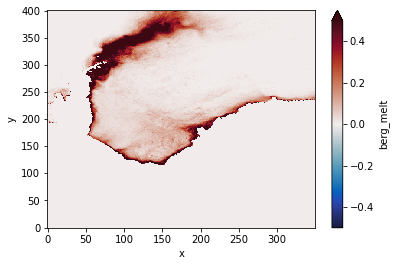

In [110]:
bergmelt.plot(vmin=-0.5,vmax=0.5,cmap=cmocean.cm.balance)

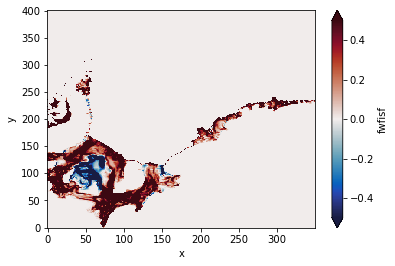

In [111]:
fwfisf.plot(vmin=-0.5,vmax=0.5,cmap=cmocean.cm.balance)

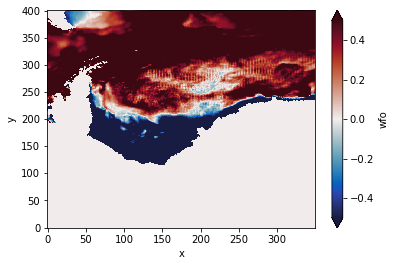

In [100]:
wfo.plot(vmin=-0.5,vmax=0.5,cmap=cmocean.cm.balance)

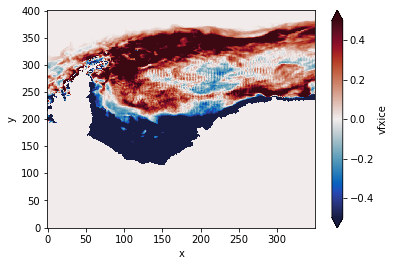

In [116]:
vfxice.plot(vmin=-0.5,vmax=0.5,cmap=cmocean.cm.balance)

Over the timeseries, see a loss of about 0.02 kg/m2/s of freshwater in the ocean surface from sources. 

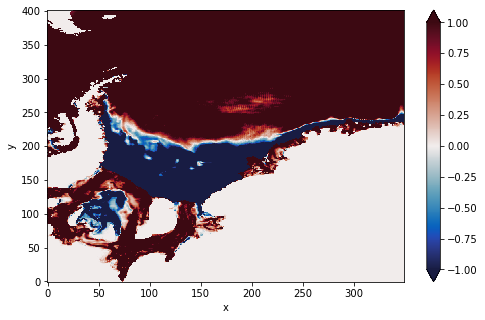

In [124]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
water_flux_into_ocean.sum(dim='time_counter').plot(ax=ax, vmin=-1, vmax=1, cmap=cmocean.cm.balance)

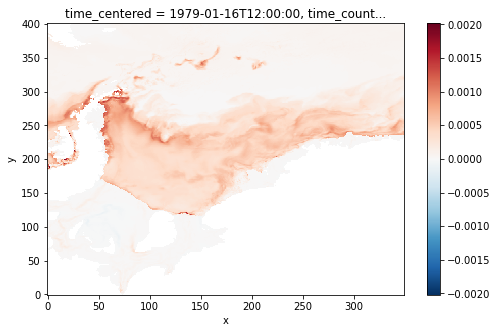

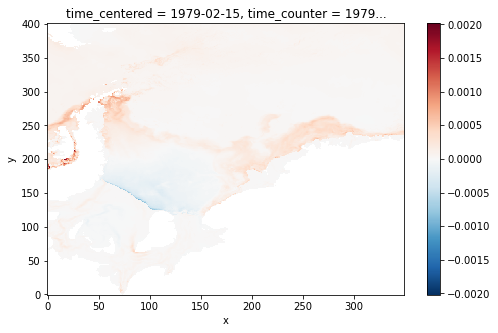

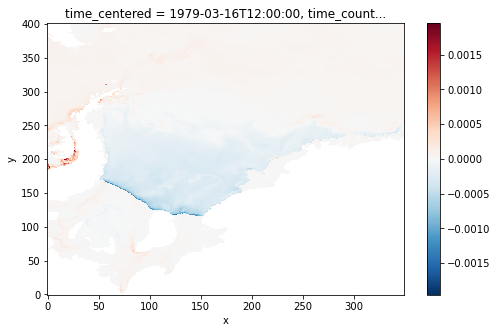

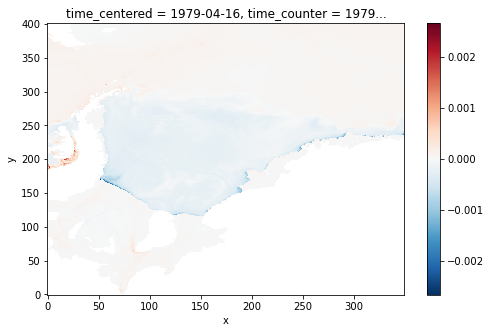

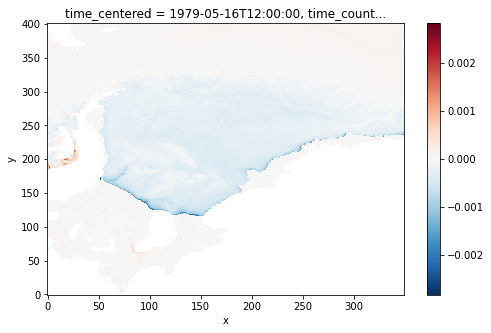

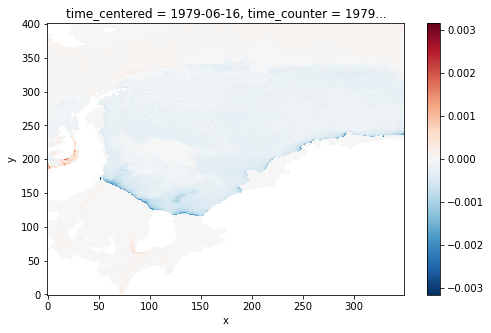

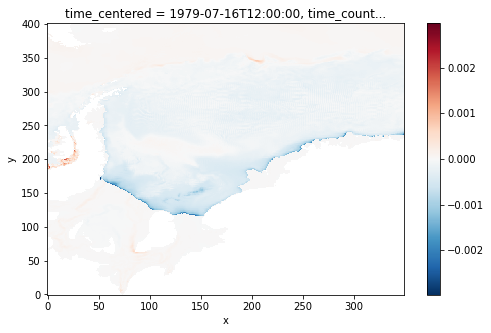

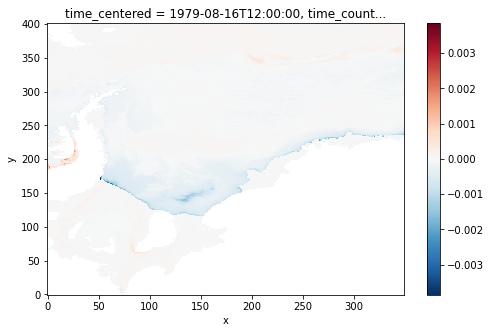

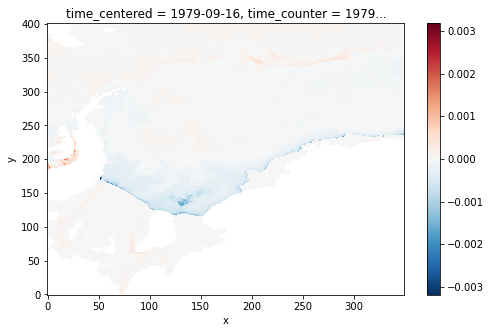

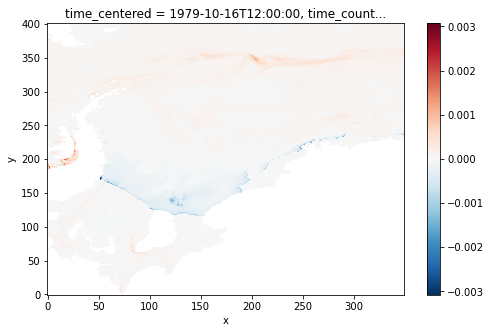

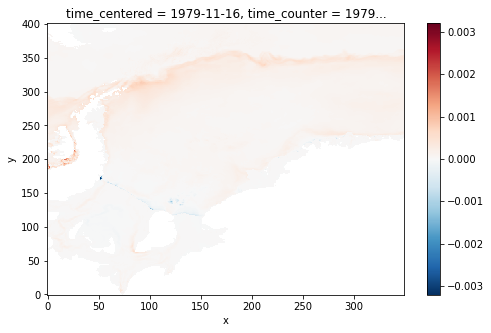

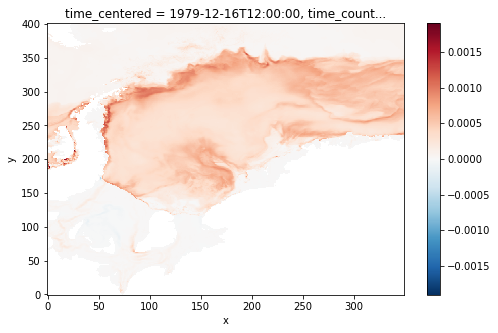

In [25]:
for month in range(0,12):
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    water_flux_into_ocean.isel(time_counter=month).plot(ax=ax)

In [5]:
# load nemo simulations
gridT_files = glob.glob(f'{run_dir}files/*grid_T*')[0:2] # load all the gridT files in the run folder
nemo_ds = xr.open_mfdataset(gridT_files).rename({'x_grid_T':'x','y_grid_T':'y'}) 

In [4]:
def extract_region_var(run_dir, var_name, region, file_slice=(0,None)):
    nemo_mesh_ds = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0, x=region['x'], y=region['y']).rename(name_remapping1)
    
    files = glob.glob(f'{run_dir}eANT025*{file_type}*')[file_slice[0]:file_slice[1]]

    area_name = 'area_grid_T'
    name_remapping2 = {'area_grid_T':'area', 'x_grid_T':'x', 'y_grid_T':'y'}
        
    kwags={'preprocess':lambda ds: ds[[var_name, area_name, 'time_counter']], 'chunks':'auto'}
    nemo_ds    = xr.open_mfdataset(files, **kwags).rename(name_remapping2)
    nemo_ds    = nemo_ds.isel(x=region['x'], y=region['y']) 
    area_ocean = nemo_ds['area'].isel(time_counter=0).expand_dims({name_remapping1['nav_lev']:nemo_ds[name_remapping1['nav_lev']]})
    area_ocean = xr.where(nemo_mesh_ds[mask].values==0, np.nan, area_ocean)
    var_ocean  = xr.where(nemo_mesh_ds[mask].values==0, np.nan, nemo_ds[var_name])
    var_ocean  = xr.where(var_ocean==0, np.nan, var_ocean)

    region_var = (var_ocean*area_ocean).sum(dim=['x','y'])/(area_ocean.sum(dim=['x','y']))
    region_var = xr.where(region_var==0, np.nan, region_var)

    return region_var, var_ocean

In [6]:
# run_dir = f'{base_dir}output/ERA5_test6_highres/files2/'
run_dir = f'{base_dir}output/ERA5_evd_test2/files/'
time_slice=(0,None)

region = weddell_overall

# # weddell_T, T         = extract_region_var(run_dir, 'thetao' , region, file_slice=time_slice, file_type='grid_T')
# # weddell_S, S         = extract_region_var(run_dir, 'so'     , region, file_slice=time_slice, file_type='grid_T')